In [91]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.datasets import make_swiss_roll # this give a 3d data sample that is in the sape of swiss roll. 

In [92]:
def sample_batch(batch_size,device = "cpu"):
    data, _ = make_swiss_roll(batch_size)  # We generate a data that looks like a swiss rolle with n_samples number of data points. 
    data = data[:,[2,0]]/10
    data = data * np.array([1,-1])
    return(torch.from_numpy(data).to(device))


In [93]:
class MLP(nn.Module):

    def __init__(self, N = 40, data_dim = 2, hidden_dim = 64):
        super(MLP, self).__init__()

        self.network_head = nn.Sequential(nn.Linear(data_dim,hidden_dim),
                                          nn.ReLU(),
                                          nn.Linear(hidden_dim,hidden_dim),
                                          nn.ReLU(),)
        self.network_tail = nn.ModuleList([nn.Sequential(nn.Linear(hidden_dim,hidden_dim),
                                           nn.ReLU(),
                                           nn.Linear(hidden_dim,data_dim * 2),) for t in range(N)])

    def forward(self,x,t):

        h = self.network_head(x) # [batch_size, hidden_dim]
        tmp = self.network_tail[t](h) # [batch_size, data_dim *2]
        mu,h = torch.chunk(tmp,2,dim=1)
        var = torch.exp(h)
        std = torch.sqrt(var)
        return mu, std

In [94]:
# model = MLP()
# torch.save(model,'model_paper1')

In [95]:
mlp_model = torch.load('model_paper1')
t = 5
x = torch.randn((2,2))
print(x)
mu, std = mlp_model(x,t)
print(mu.shape)
print(std.shape)
print(mu)
print(std)
mlp_model

tensor([[ 0.6582, -0.6883],
        [ 1.4634, -2.2035]])
torch.Size([2, 2])
torch.Size([2, 2])
tensor([[-0.1340,  0.0681],
        [-0.1844,  0.1265]], grad_fn=<SplitBackward0>)
tensor([[1.0900, 1.0495],
        [1.1478, 1.0163]], grad_fn=<SqrtBackward0>)


MLP(
  (network_head): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
  )
  (network_tail): ModuleList(
    (0-39): 40 x Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=4, bias=True)
    )
  )
)

In [96]:
MLP()

MLP(
  (network_head): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
  )
  (network_tail): ModuleList(
    (0-39): 40 x Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=4, bias=True)
    )
  )
)

### Forward diffusion Kernel 

$$\mathcal{N}\left(x^{(t)},\underbrace{x^{(t-1)}\sqrt{1-\beta_t}}_{\text{mu}},\underbrace{I \beta_t}_{\text{std}} \right)$$


We are uisng the reparamatriztion tecnic

In [131]:
class DiffusionModule():

    def __init__(self,T, model: nn.Module,dim = 2):
        self.betas = torch.sigmoid(torch.linspace(-18,10,T)) * (3e-1 - 1e-5) + 1e-5
        self.alphas = 1 - self.betas
        self.alphas_bar = torch.cumprod(self.alphas,0)
        self.T = T
        self.model = model
        self.dim = dim

    def forward_porcess(self,x0, t):
        """
        :param data: data
        :param t: Number of diffusion steps
        """

        assert t > 0, 'ArithmeticError: t must be gratter thin zero'

        t = t -1 # Becouse we are starting indexing at 0 

        mu = torch.sqrt(self.alphas_bar[t]) * x0
        std =  torch.sqrt(1-self.alphas_bar[t])
        epsilon =  torch.randn_like(x0)
        xt = mu + torch.randn_like(x0) * std 
 
        sigma_q = torch.sqrt(((1-self.alphas_bar[t-1])/(1-self.alphas_bar[t]))*self.betas[t]) 
        m1 = (torch.sqrt(self.alphas_bar[t-1]) * self.betas[t] ) / (1- self.alphas_bar[t])
        m2 =  (torch.sqrt(self.alphas[t])* (1- self.alphas_bar[t-1]))/ (1- self.alphas_bar[t])
        mu_q = m1*x0 + m2 *xt


        return mu_q, sigma_q, xt

    def reverse_process(self, xt, t):

        assert t > 0, 't should be greatter then zero'
        assert t <= self.T, 't should be less then or equl to self.T'

        t = t - 1 # becouse we are starting indexing at 0 
        mu, std = self.model(xt, t)
        epsilon =  torch.randn_like(xt)
        return mu,std, mu + torch.randn_like(xt) * std 

    def sample(self,batch_size):

        noise = torch.randn((batch_size,self.dim))
        x = noise 

        samples = [x]
        for t in range(self.T, 0 , -1):
            _,_,x = self.reverse_process(x,t)
            samples.append(x)

        return samples

    def get_loss(self,x0):
        """ 
        :param x0: batch [batch_size, self.dim]
        """

        t = torch.randint(2,40+1,(1,))
        mu_q, sigma_q, xt = self.forward_porcess(x0,t)
        mu_p, sigma_p, xt_minus1 = self.reverse_process(xt.float(),t)

        KL = torch.log(sigma_p) - torch.log(sigma_q) - (sigma_q**2 + (mu_q - mu_p)**2)/(2* sigma_p **2)
        K =  - KL.mean() # should be mazimise 
        loss = - K # should be minimised 
        return loss

In [132]:
print(list(range(40,0,-1))) 



[40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]


In [133]:
model = DiffusionModule(40,mlp_model)


In [134]:
samples = model.sample(1000)

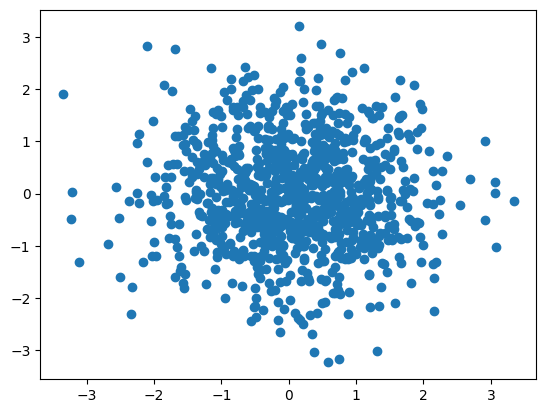

In [135]:
plt.scatter(samples[2][:,0].data.numpy(), samples[2][:,1].data.numpy())

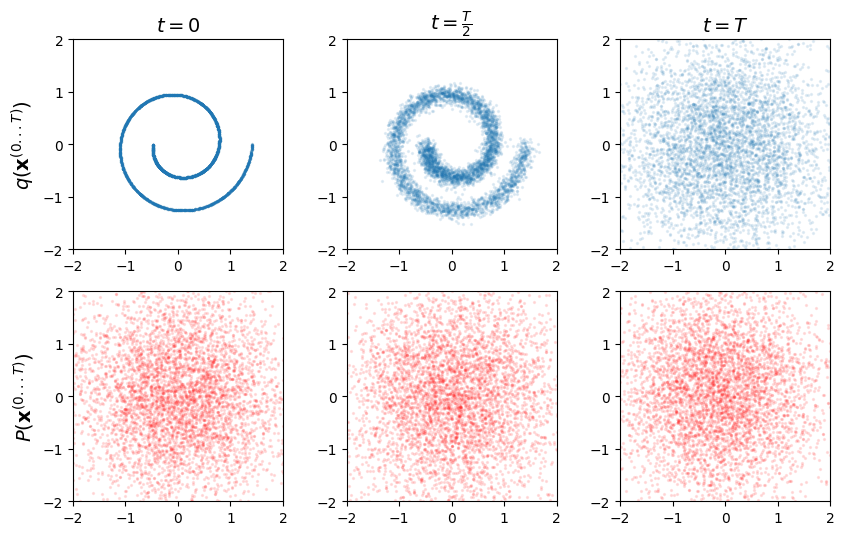

In [136]:
fontsize = 14
fig = plt.figure(figsize = (10,6))
N = 5_000
x0 = sample_batch(N)
samples = model.sample(N)


data = [x0, model.forward_porcess(x0,20)[-1],model.forward_porcess(x0,40)[-1]]
for i in range(3):
    plt.subplot(2,3,1+i)
    plt.scatter(data[i][:,0].data.numpy(),data[i][:,1].data.numpy(),alpha=0.1,s=2)
    plt.xlim([-2,2])
    plt.ylim([-2,2])
    plt.gca().set_aspect('equal')


    if i == 0: plt.ylabel(r'$q(\mathbf{x}^{(0...T)})$',fontsize = fontsize)
    if i == 0: plt.title(r'$t=0$',fontsize = fontsize)
    if i == 1: plt.title(r'$t=\frac{T}{2}$',fontsize = fontsize)
    if i == 2: plt.title(r'$t=T$',fontsize = fontsize)
time_step = [0,20,40]
for i in range(3):
    plt.subplot(2,3,4+i)
    plt.scatter(samples[time_step[i]][:,0].data.numpy(),samples[time_step[i]][:,1].data.numpy(),alpha=0.1,c= 'r',s=2)
    plt.xlim([-2,2])
    plt.ylim([-2,2])
    plt.gca().set_aspect('equal')


    if i == 0: plt.ylabel(r'$P(\mathbf{x}^{(0...T)})$',fontsize = fontsize)

In [150]:
x0 = sample_batch(128)
model.get_loss(x0)

tensor(5.2507, dtype=torch.float64, grad_fn=<NegBackward0>)